## Practical 5

In this practical, we will focus on conducting reproducible and robust research. We will piece together most parts of the knowledge we have gathered in the course. Therefore, this practical can be seen as writing a mini-thesis, or at the very least a proposal for one. Please note that these are by no means strict guidelines, and they only scratch the surface. We hope you find that it will feature some useful tips and tricks you will be able to apply in the future (like all prior notebooks). Unlike the previous practicals, there will not be tasks leading to questions for you to answer.

### The initial idea

The motivation of the exercises of this notebook is based on the DeepMoji model, a sentiment classifier. In particular, we will collect the same type of data, train a sentiment classifier, and see if the techniques they use can generalize to different data (i.e., to a different domain).

It should be mentioned that DeepMoji was trained on Tweets, so we will test if it can also predict the sentiment of Yelp (restaurant) reviews. For a technique to be a ‘general’ sentiment predictor, it should work on these reviews. This contribution is our scientific relevance. Then, what is the societal relevance? Sentiment analysis has a broad application in marketing, social sciences, crisis analyses, etc. 

Therefore, our proposal will also include simple models, explainable models, which we can compare to the DeepMoji.

This brings us to the research question(s):
- To what extent can we reproduce the DeepMoji paper?
- How closely can we match performance with a new dataset?
- Do simple classifiers achieve comparable performance?
- Does our model generalize to a different domain?

### Data
Note: We have already gathered the data for this practical and you do not have to execute the following code. This part is for information only.

We start by setting up the collection of data from Twitter. The Twitter API allows you to access part of their data after  registering for keys in this link:
https://developer.twitter.com/en
(Twitter account required). 

We use ``tweepy``, you can see more info on https://cmry.github.io/notes/twitter-python). As such:

```
import tweepy

auth = tweepy.OAuthHandler("XXXX", "XXXX")
auth.set_access_token("XXXX", "XXXX")
api = tweepy.API(auth)
```

The "XXXX" parts are where your own keys should go after you register. We then have this piece of code for retrieval:

```
from time import sleep

for n_queries in range(120):

    with open('emoji-data.txt', 'a') as of:
        emoji_dict = {"🙂": "happy", "🙁": "sad", "😠": "angry", "❤️": "love"}
        for emoji, label in emoji_dict.items():
            for tweet in api.search(emoji, lang="en", include_entities=False):
                jsf = tweet._json
                jsf.pop('metadata')
                jsf.pop('user')
                try:
                    jsf.pop('entities')
                except:
                    pass
                of.write(label + " | " + str(jsf) + "\n")
        sleep(30)
```

**Code explained.** The dictionary keys contain emojis. First, we perform 120 queries and append them to our data file (notice that we can restart the code and keep collecting). Per emoji in our dictionary, we launch a separate query (api.search), restrict the language to English, and do not include a bunch of extra information. Next, we remove some additional stuff from the JSON for each tweet in the retrieved data and then write the return object plus our label to file. Finally, we need to wait 30 seconds between each query.

#### Testing our Data
A logical first step before anything else would be to see if the models trained on our data work. If we can’t predict emojis (or sentiment, rather) for a test set with other Tweets, we cannot really hope to perform well on a benchmark set, let alone out-of-domain data. The collected is provided with this notebook. The data is stored in a ``<label> | <JSON_file>`` format, which we first have to split. This will give us a line as shown below:

In [1]:
data_dir = 'research/'
open(data_dir + 'emoji-data.txt', encoding="utf8").read().split('\n')[0]

'happy | {\'created_at\': \'Sat Oct 10 22:33:51 +0000 2020\', \'id\': 1315057988470743041, \'id_str\': \'1315057988470743041\', \'text\': \'@melemel2012 @JackPosobiec Great parenting 😊\', \'truncated\': False, \'source\': \'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>\', \'in_reply_to_status_id\': 1314987700018130944, \'in_reply_to_status_id_str\': \'1314987700018130944\', \'in_reply_to_user_id\': 412322037, \'in_reply_to_user_id_str\': \'412322037\', \'in_reply_to_screen_name\': \'melemel2012\', \'geo\': None, \'coordinates\': None, \'place\': None, \'contributors\': None, \'is_quote_status\': False, \'retweet_count\': 0, \'favorite_count\': 0, \'favorited\': False, \'retweeted\': False, \'lang\': \'en\'}'

**Important note.** We have added the parameter `encoding="utf8"` to read this file properly in Python 3, otherwise we might get a encoding error and we could not continue. The next line splits the label and the JSON in a list:

In [2]:
open(data_dir + 'emoji-data.txt', encoding="utf8").read().split('\n')[0].split('|')

['happy ',
 ' {\'created_at\': \'Sat Oct 10 22:33:51 +0000 2020\', \'id\': 1315057988470743041, \'id_str\': \'1315057988470743041\', \'text\': \'@melemel2012 @JackPosobiec Great parenting 😊\', \'truncated\': False, \'source\': \'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>\', \'in_reply_to_status_id\': 1314987700018130944, \'in_reply_to_status_id_str\': \'1314987700018130944\', \'in_reply_to_user_id\': 412322037, \'in_reply_to_user_id_str\': \'412322037\', \'in_reply_to_screen_name\': \'melemel2012\', \'geo\': None, \'coordinates\': None, \'place\': None, \'contributors\': None, \'is_quote_status\': False, \'retweet_count\': 0, \'favorite_count\': 0, \'favorited\': False, \'retweeted\': False, \'lang\': \'en\'}']

If we select the first element, we can see the JSON. As it was not saved before, we have to use `eval()` to convert it back to a JSON / dictionary format and visualize it in the form of dictionary as visualized below:

In [3]:
eval(open(data_dir + 'emoji-data.txt', encoding="utf8").read().split('\n')[0].split('|')[1])

{'created_at': 'Sat Oct 10 22:33:51 +0000 2020',
 'id': 1315057988470743041,
 'id_str': '1315057988470743041',
 'text': '@melemel2012 @JackPosobiec Great parenting 😊',
 'truncated': False,
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'in_reply_to_status_id': 1314987700018130944,
 'in_reply_to_status_id_str': '1314987700018130944',
 'in_reply_to_user_id': 412322037,
 'in_reply_to_user_id_str': '412322037',
 'in_reply_to_screen_name': 'melemel2012',
 'geo': None,
 'coordinates': None,
 'place': None,
 'contributors': None,
 'is_quote_status': False,
 'retweet_count': 0,
 'favorite_count': 0,
 'favorited': False,
 'retweeted': False,
 'lang': 'en'}

Given the latter output, you can see that we have a bunch of extra information that came with the Twitter API, such as the date, the number of likes, retweets, the geolocation (if provided), and the text of the tweet itself. Next, we essentially apply the operations above (splitting the lines, evaluating the JSON part) but then append them to two lists (one for text and one for labels). These are at the end stored in a DataFrame.

In [4]:
text, labels = [], []
for line in open(data_dir + 'emoji-data.txt', encoding="utf8").read().split('\n'):
    try:
        label, jsonf = line.split(' | ')
        text.append(eval(jsonf)['text'])
        labels.append(label)
    except:
        continue

In [5]:
import pandas as pd

df = pd.DataFrame({'text': text, 'labels': labels})
df.head()

,text,labels
0,@melemel2012 @JackPosobiec Great parenting 😊,happy
1,RT @copter_chief: .@realDonaldTrump Once AG Ba...,happy
2,@mummybunz21 @shawneda @TheSims @TheSimCommuni...,happy
3,RT @JSimoncavage: I know I'm cute and this is ...,happy
4,RT @GoldenTreeCIC: Repeat daily and develop a ...,happy


To save memory, we are going to delete our text and label variables, as they are in the DataFrame now anyways:

In [6]:
del text, labels

Let’s see what labels we have:

<AxesSubplot:>

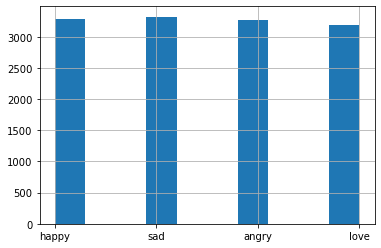

In [7]:
plot = df.labels.hist()

You will notice that these are all nicely distributed (this happens because the data was collected that way). Now, we could go through the effort of fitting a classifier we the data we have and confirm that the prediction performances on the test are pretty low.

However, this time we will spoil the problem immediately: there are duplicate tweets in this dataset. 

Generally, that means that the classifier will overfit these particular tweets, and therefore perform poorly on others. Moreover, another issue is that our data is not that big (one hour's worth of data is not much). For completeness, we will go through solving the duplicates issue and assessing the evaluation scores. First, we want to drop the overlapping tweets, which we can do with Pandas:

In [8]:
print(len(df))
df.drop_duplicates(subset=['text'], inplace=True)
print(len(df))

13070
5922


Note that subset is used to indicate the column where we want to detect the duplicates, and we print the length of the DataFrame before and after dropping. Now we convert the different emojis to positive and negative sentiment:

In [9]:
df.replace({"labels": {'happy': 1, 'sad': 0, 'angry': 0, 'love': 1}}, inplace=True)
df.head()

,text,labels
0,@melemel2012 @JackPosobiec Great parenting 😊,1
1,RT @copter_chief: .@realDonaldTrump Once AG Ba...,1
2,@mummybunz21 @shawneda @TheSims @TheSimCommuni...,1
3,RT @JSimoncavage: I know I'm cute and this is ...,1
4,RT @GoldenTreeCIC: Repeat daily and develop a ...,1


Next, we divide our data in two hold-out splits:

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(df.text, df.labels, stratify=df.labels, random_state=42)

There are two important things to be discussed here. The first one is stratifying based on the label distribution and the second one is setting a seed with ``random_state``. The latter is important for reproducibility; ``scikit-learn`` by default randomly shuffles the data (to avoid the order playing a part in the predictions). To make sure that it is the same random shuffle every time, we provide a seed. Now we can run our classifier:

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer()
Xf_train = cv.fit_transform(X_train)

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(Xf_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Notice that we again have a seed, this time for our Logistic Regression model, as we need to fix the randomness in the solver. Always check the documentation if there is a seed possibility somewhere. Even numpy has a seed. Now we check performance:

In [13]:
from sklearn.metrics import classification_report
y_pred = lr.predict(cv.transform(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.45      0.54       530
           1       0.74      0.88      0.81       951

    accuracy                           0.73      1481
   macro avg       0.71      0.67      0.67      1481
weighted avg       0.72      0.73      0.71      1481



Here we can see Precision, Recall, Accuracy, F1 score, class frequencies, everything. These figures are meaningless without a baseline, so let’s use a majority one, predicting 1 for all instances:

In [17]:
print(classification_report(y_test, len(y_pred) * [1]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       530
           1       0.64      1.00      0.78       951

    accuracy                           0.64      1481
   macro avg       0.32      0.50      0.39      1481
weighted avg       0.41      0.64      0.50      1481



C:\Users\20214772\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\20214772\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\20214772\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Note that we replaced the actual predictions with a list having the length of the dataset instances. You are encouraged to try other classifiers, but as you can see, the performance is pretty bad. The performance can undoubtedly be improved with more data collection, but we will decide that we can not currently reproduce the data collection method for this practical. Therefore, we will focus on this benchmark data —as that is also Twitter— and see if we can use simple models to predict Yelp reviews. 
This would at least give us some indication of the Emoji idea is worth pursuing.

#### Preparing the out-of-domain Data

The out-of-domain (meaning it is a different domain than the data of interest) data was gathered from Kaggle. As we can see, it contains a few labels in addition to the review score, but we’re only interested in the latter.

In [18]:
df = pd.read_csv(data_dir + 'yelp.csv')
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


Now we also want to have a careful look at those labels. Note that we overwrite the previous ``df`` as we stored it in train and test splits, and we do not want to keep big dataframe objects in memory if they are unused.

<AxesSubplot:>

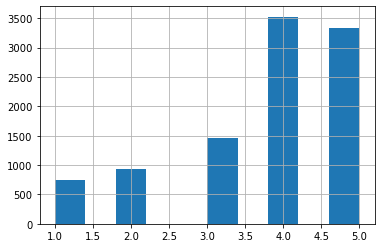

In [19]:
plot = df.stars.hist()

As you can see, the data has mostly positive labels. Before we proceed, we have to talk about what this set has to do with sentiment prediction. There are no labels for positive and negative, right? It turns out that (unsurprisingly) review scores are actually a good proxy for sentiment recognition!

However, we will have to push these scores to positive/negative somehow. Given the uneven label distribution, we might want to make a selection for this binary task specifically. Firstly, we replace items in the column stars by values we provide (either 1, -1, or 0). In this encoding, one will be positive, zero will be negative, and we will use -1 as an identifier for the rows we want to delete. In the next line, we first locate all the rows where df.stars is -1, and get their index (drop needs indices). Both replace and drop will be done ``inplace`` so no need to do a ``df =`` there.

In [20]:
df.replace({"stars": {5: 1, 4: -1, 3: -1, 2: 0, 1: 0}}, inplace=True)
df.drop(df.loc[df.stars == -1].index, inplace=True)

Now we can put them in separate train and test splits, which we want to store separately because this will be our data to test generalization. We will therefore prepend them with an underscore:

In [21]:
_X_train, _X_test, _y_train, _y_test = train_test_split(df.text, df.stars, stratify=df.stars, random_state=42)

You can see that our test set is not extremely imbalanced:

array([[<AxesSubplot:title={'center':'stars'}>]], dtype=object)

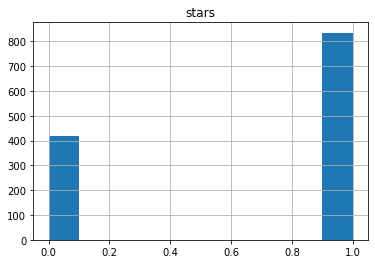

In [22]:
pd.DataFrame(_y_test).hist()

Now, let us again determine how difficult this task is with a simple Logistic Regression baseline:

In [23]:
cv = TfidfVectorizer()
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(cv.fit_transform(_X_train), _y_train)
_y_pred = lr.predict(cv.transform(_X_test))
print(classification_report(_y_test, _y_pred))
print(classification_report(_y_test, len(_y_pred) * [1]))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83       419
           1       0.88      0.97      0.93       835

    accuracy                           0.90      1254
   macro avg       0.91      0.86      0.88      1254
weighted avg       0.90      0.90      0.89      1254

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       419
           1       0.67      1.00      0.80       835

    accuracy                           0.67      1254
   macro avg       0.33      0.50      0.40      1254
weighted avg       0.44      0.67      0.53      1254



C:\Users\20214772\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\20214772\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\20214772\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


If we input the same random_states, this model should report an accuracy of about 90%, and the baseline is 67%. The F1 scores for LR are also significantly higher. Anyways, good news! We can actually predict if something gets a low or a high score. Finally, let us prepare our Twitter data. This is actually a dictionary / JSON file in the following code, but it is stored in a pickle format, which is a binary image of the Python object. We simply load it, select the entries we want: ``texts`` and ``labels`` (the latter of which is under ``info``) and put that in a DataFrame.

In [25]:
import pickle

data = pickle.load(open(data_dir + 'twitter.pickle', 'rb'))
df = pd.DataFrame({'texts': data['texts'], 'labels': [x['label'] for x in data['info']]})
df.head(10)

,texts,labels
0,"Listening to the ""New Age"" station on @Slacker...",1
1,i didnt mean knee high I ment in lengt it goes...,1
2,I wana see the vid Kyan,1
3,if my mom went on for the love of ray J or any...,0
4,@Mrhilton1985 Welcome to Twitter xx,1
5,"@kjbmusic oh yeah... however, I'd still like t...",1
6,I need a nice tea-drinking pic for our #Tea Cl...,1
7,"@JonathanRKnight so twitpic it lol, I love Hom...",1
8,"@BarCough it's enough to make you sick, eh? th...",0
9,"""Iran, with its unity and God's grace, will pu...",0


<AxesSubplot:>

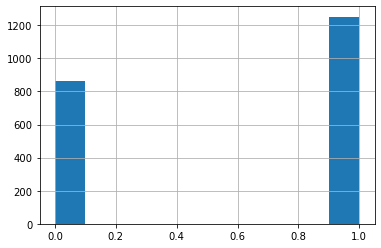

In [26]:
plot = df.labels.hist()

The label distribution looks close to what we also found in our Tweets, promising! Let us run a final baseline:

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df.texts, df.labels, stratify=df.labels, random_state=42)
cv = TfidfVectorizer()
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(cv.fit_transform(X_train), y_train)
y_pred = lr.predict(cv.transform(X_test))
print(classification_report(y_test, y_pred))
print(classification_report(y_test, len(y_pred) * [1]))

              precision    recall  f1-score   support

           0       0.73      0.43      0.54       216
           1       0.69      0.89      0.78       313

    accuracy                           0.70       529
   macro avg       0.71      0.66      0.66       529
weighted avg       0.71      0.70      0.68       529

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       216
           1       0.59      1.00      0.74       313

    accuracy                           0.59       529
   macro avg       0.30      0.50      0.37       529
weighted avg       0.35      0.59      0.44       529



C:\Users\20214772\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\20214772\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\20214772\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The Logistic Regression does not improve the Majority Baseline significantly: 10% the accuracy and 30% the F1 score, which is actually a good increase, but the final score is not that impressive. Therefore, there is plenty of room for tackling this task properly.

### Experimental Set-up
So far, we have only been pre-exploring data and ran some simple baselines. It is time to think about our experimental setup. How are we going to use this out-of-domain set to assess generalization? We can use the scores we obtained in the previous part to see how well our Twitter dataset generalizes. We will take the classification scores on that set, the Yelp dataset, and then see how far performance drops of the Twitter sentiment classifier to the Yelp dataset. Note that we purposefully ran models as baselines (in addition to the majority baseline), so we have a rough estimate of how an optimized pipeline should at the very least be expected to perform on this data. 

We would describe what models we run, which hyper-parameters we tune, what evaluations we use, etc. For the sake of simplicity, we will use ``tf*idf`` features, Logistic Regression, and evaluate our models on F1 score (as the sets are slightly unbalanced). We will run a grid search procedure to fine-tune some parameters and evaluate the best setting using 10-fold cross-validation.

If we were to look at more models, nested cross-validation would be more appropriate. The potential models we apply should be simple. If you want to use other models such as Multinomial Naive Bayes or and k-Nearest Neighbors, feel free to change the code below.

#### Tuning with Grid Search
First, we will define a pipeline. This is a scikit-learn component that makes it convenient to change multiple components together. We can simply call ``pipeline.fit(some_data)`` and it will run all the components in order. We define it as such:

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

pipeline = Pipeline([
                    ('cv', CountVectorizer()),
                    ('tf', TfidfTransformer()),
                    ('lr', LogisticRegression(random_state=42)),
                    ])

This also makes it very convenient for grid search because the identifiers (cv, tf, lr) can be used to set parameter ranges:

In [35]:
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'cv__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'cv__ngram_range': ((1, 1), (1, 2)), # unigrams or bigrams
    'tf__use_idf': (True, False),
    'tf__norm': ('l1', 'l2'),
    # 'lr__max_iter': (1000, ),
    'lr__C': (1000, 1000, 10, 1, 0.01, 0.001, 0.0001, 0.00001),
    # 'lr__penalty': ('l2', 'none'),
}

The syntax here is ``id__parameter_name``. The parameter names can be found under their respective documentation pages. Using both our pipeline and the parameters, we can run a grid search procedure to fine-tune them. This will create a ‘hidden’ development/validation set in the cross-validation of the method itself—**so no need to split it ourselves**.

In [31]:
import warnings # to get rid of too much output
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipeline, parameters, cv=10, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('tf', TfidfTransformer()),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             param_grid={'cv__max_df': (0.5, 0.75, 1.0),
                         'cv__ngram_range': ((1, 1), (1, 2)),
                         'lr__C': (1000, 1000, 10, 1, 0.01, 0.001, 0.0001,
                                   1e-05),
                         'tf__norm': ('l1', 'l2'),
                         'tf__use_idf': (True, False)},
             verbose=1)

Note that we i) set a cross-validation procedure (cv=10) and ii) fit a grid search on our training split. This will automatically figure out the best performing set of parameters (and best model) for us. We can access these attributes as shown below:

In [32]:
print("Best score:", grid_search.best_score_)
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t", param_name, ":", best_parameters[param_name])

Best score: 0.7455616591035745
	 cv__max_df : 0.5
	 cv__ngram_range : (1, 2)
	 lr__C : 1000
	 tf__norm : l2
	 tf__use_idf : True


This will give us the score of the best-performing model and its hyper-parameters. Finally, we can extract that model from the grid search pipeline, and either re-fit it on the entire training dataset or immediately apply it to the test set:

In [33]:
clf = grid_search.best_estimator_
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.61      0.65       216
           1       0.75      0.83      0.79       313

    accuracy                           0.74       529
   macro avg       0.73      0.72      0.72       529
weighted avg       0.73      0.74      0.73       529



After about five minutes, it should be done fitting (if you kept the original grid), and we know if our tuned model performs better than our naive ``tf*idf`` + LR baseline. Overall it should be about 5% better on all metrics. Not too shabby for only a few parameters and one model!

**Important note.** Grid search is a time-intensive procedure and it can take a while depending on the hardware you have. Therefore, it might be the case that it takes longer than five minutes, as mentioned above. Patience is advised.

#### Domain Generalization
In the next step, we will explore how well our model generalizes to another domain (from Twitter data to Yelp data). Remember that we had saved them in ``_X_test`` and ``_y_test``, so these pieces of data can be used at any time.

In [34]:
_y_pred = clf.predict(_X_test)
print(classification_report(_y_test, _y_pred))

              precision    recall  f1-score   support

           0       0.60      0.69      0.64       419
           1       0.83      0.77      0.80       835

    accuracy                           0.75      1254
   macro avg       0.72      0.73      0.72      1254
weighted avg       0.76      0.75      0.75      1254



We can notice that we obtain similar performance on Yelp as on our test set! Although definitely lower than the Yelp model itself, this is a very promising result. Now, we can spend all our future research time collecting more emoji data, experimenting with different models, investigating the learned features, comparing the dataset with some descriptives, etc. However, that’s all for this practical.

**Interesting note.** This practical is related to a popular research sub-field in machine learning known as **transfer learning**. Such a sub-field focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks. This area of research bears some relation to the long history of psychological literature on transfer learning, although practical ties between the two fields are limited. 